In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
ANTHROPIC_API_KEY = os.environ.get('ANTHROPIC_API_KEY')
OPENAI_API_KEY = os.environ.get('OPENAI_API_KEY')
GEMINI_API_KEY = os.environ.get('GEMINI')

In [5]:
# judge_slides.py
# pip install google-genai pillow pandas tqdm
import os, json, glob, re, base64
from pathlib import Path
from typing import Dict, List, Any
from openai import OpenAI

import pandas as pd
from tqdm import tqdm
from PIL import Image
from google import genai
from google.genai import types

# ------------------------------------------------------------------
# 0. 환경 설정 ------------------------------------------------------
MODEL_NAME = "gpt-4o"
MAX_TOKENS = 512                                    # 필요하면 조정

ROOT = Path(".")                                    # 프로젝트 루트
ORIG_IMG_DIR  = ROOT / "evaluation/benchmark_ppts/images"
ORIG_NOTE_DIR = ROOT / "evaluation/benchmark_ppts/notes"

EDIT_IMG_DIR  = ROOT / "result_ufo_evaluation/images"
EDIT_NOTE_DIR = ROOT / "result_ufo_evaluation/notes"
LOG_PATH      = ROOT / "result_ufo_evaluation/ufo_experiment_log.jsonl"

OUT_PATH      = ROOT / "judge_results_ufo.jsonl"   # 평가 결과 저장
SUMMARY_PATH  = ROOT / "evaluation_summary_ufo.csv"


# EDIT_IMG_DIR  = ROOT / "result/images"
# EDIT_NOTE_DIR = ROOT / "result/notes"
# LOG_PATH      = ROOT / "result/experiment_log.jsonl"

# OUT_PATH      = ROOT / "judge_results_ours.jsonl"   # 평가 결과 저장
# SUMMARY_PATH  = ROOT / "evaluation_summary_ours.csv"

# instruction_key → 카테고리 매핑
CATEGORY_MAP = {
  "0": "TextEditing",  "1": "TextEditing",   "2": "TextEditing",
  "3": "TextEditing",  "4": "TextEditing",   "5": "TextEditing",
  "6": "TextEditing",  "7": "TextEditing",   "8": "TextEditing",
  "9": "TextEditing", "10": "TextEditing",  "11": "VisualFormatting",
  "12": "VisualFormatting", "13": "TextEditing",  "14": "VisualFormatting",
  "15": "TextEditing", "16": "VisualFormatting",  "17": "LayoutAndImageAdjustment",
  "18": "VisualFormatting", "19": "TextEditing",  "20": "VisualFormatting",
  "21": "VisualFormatting", "22": "VisualFormatting", "23": "VisualFormatting",
  "24": "VisualFormatting", "25": "VisualFormatting", "26": "VisualFormatting",
  "27": "VisualFormatting", "28": "VisualFormatting", "29": "LayoutAndImageAdjustment",
  "30": "LayoutAndImageAdjustment", "31": "LayoutAndImageAdjustment",
  "32": "LayoutAndImageAdjustment", "33": "LayoutAndImageAdjustment",
  "34": "LayoutAndImageAdjustment", "35": "LayoutAndImageAdjustment",
  "36": "LayoutAndImageAdjustment", "37": "LayoutAndImageAdjustment",
  "38": "LayoutAndImageAdjustment", "39": "LayoutAndImageAdjustment",
  "40": "VisualFormatting", "41": "VisualFormatting", "42": "VisualFormatting",
  "43": "LayoutAndImageAdjustment", "44": "LayoutAndImageAdjustment",
  "45": "VisualFormatting", "46": "SlideStructure", "47": "SlideStructure",
  "48": "SlideStructure", "49": "LayoutAndImageAdjustment",
  "50": "SlideStructure", "51": "SlideStructure", "52": "SlideStructure",
  "53": "VisualFormatting", "54": "TextEditing", "55": "TextEditing"
}

# ------------------------------------------------------------------
# 1. Gemini client 초기화 ------------------------------------------
#client = genai.Client(api_key=GEMINI_API_KEY)
client = OpenAI(api_key=OPENAI_API_KEY)

# ------------------------------------------------------------------
PROMPT_HEADER = (
    "You are an expert slide-editing judge.\n\n"
    "TASK\n"
    "- Compare the ORIGINAL slide with the EDITED slide.\n"
    "- Decide how well the EDITED slide follows the INSTRUCTION and how aesthetically pleasing it is.\n\n"
    "SCORING\n"
    'Return valid JSON with exactly these keys:\n'
    '{\n  \"instruction_adherence\": <int 0-5>,\n'
    '  \"visual_quality\":       <int 0-5>\n'
    '}\n\n'
    "GUIDELINES\n"
    "Score each from 0 to 5, based on the following rubric:\n"
    "5 = Perfect: Fully satisfies the instruction / visually excellent with no flaws.\n"
    "4 = Mostly correct: Clearly reflects the instruction / visually strong but with minor flaws.\n"
    "3 = Partially correct: Instruction was followed to a noticeable degree, but key aspects are missing or flawed / visual layout or formatting needs improvement.\n"
    "2 = Slightly changed but inadequate: Some edits related to the instruction are present but insufficient or poorly done / visual design is lacking.\n"
    "1 = Attempted but incorrect: Some change is visible, but it does not match the instruction / visual result is clearly poor.\n"
    "0 = Completely fails: No meaningful attempt to follow the instruction / visually broken or irrelevant.\n\n"
    "Judge only what you can see in the given image(s) and notes.\n"
    "Return *only* the JSON object, nothing else."
)

def load_first(path_glob: Path, exts=("*.png", "*.jpg", "*.jpeg")) -> Path:
    """Return first file path matched inside a directory."""
    for ext in exts:
        files = sorted(path_glob.glob(ext))
        if files:
            return files[0]
    raise FileNotFoundError(f"No image found in {path_glob}")

def encode_image_base64(image_path):
    """Convert image to base64 for OpenAI API."""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def build_messages(
    orig_img, orig_note,
    edit_img, edit_note,
    instruction: str
):
    """Build messages for OpenAI API."""
    messages = [{"role": "system", "content": PROMPT_HEADER}]
    
    # Create content pieces
    content = []
    
    # Original slide
    content.append({"type": "text", "text": "ORIGINAL_SLIDE_IMAGE"})
    content.append({
        "type": "image_url",
        "image_url": {
            "url": f"data:image/png;base64,{encode_image_base64(orig_img)}"
        }
    })
    
    # Original notes
    orig_note_text = "ORIGINAL_SLIDE_NOTES:\n" + (orig_note.read_text(encoding="utf-8") if orig_note and orig_note.exists() else "")
    content.append({"type": "text", "text": orig_note_text})
    
    # Instruction
    content.append({"type": "text", "text": f"INSTRUCTION:\n{instruction}"})
    
    # Edited slide
    content.append({"type": "text", "text": "EDITED_SLIDE_IMAGE"})
    content.append({
        "type": "image_url",
        "image_url": {
            "url": f"data:image/png;base64,{encode_image_base64(edit_img)}"
        }
    })
    
    # Edited notes
    edit_note_text = "EDITED_SLIDE_NOTES:\n" + (edit_note.read_text(encoding="utf-8") if edit_note and edit_note.exists() else "")
    content.append({"type": "text", "text": edit_note_text})
    
    # Response request
    content.append({"type": "text", "text": "Respond now."})
    
    messages.append({"role": "user", "content": content})
    return messages

def ask_gpt4o(messages, debug=False):
    """Send request to OpenAI API."""
    try:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=messages,
            max_tokens=MAX_TOKENS,
            response_format={"type": "json_object"}
        )
        
        full_response = response.choices[0].message.content
        
        if debug:
            print("\n===== PROMPT (truncated) =====")
            for msg in messages:
                print(f"Role: {msg['role']}")
                if isinstance(msg.get('content'), list):
                    for item in msg['content']:
                        if item['type'] == 'text':
                            print(item['text'][:200].replace("\n", " ")[:400])
                        else:
                            print(f"[Image content]")
                else:
                    print(msg.get('content', '')[:200].replace("\n", " ")[:400])
            print("\n===== RAW RESPONSE =====")
            print(full_response[:1000])
            print("========================\n")
        
        try:
            return json.loads(full_response)
        except Exception:
            # Try to extract JSON if the model didn't return pure JSON
            json_match = re.search(r"\{.*\}", full_response, re.S)
            if json_match:
                return json.loads(json_match.group(0))
            else:
                return {
                    "instruction_adherence": None,
                    "visual_quality": None,
                    "comment": f"PARSE_ERROR: {full_response[:200]}"
                }
    except Exception as e:
        return {
            "instruction_adherence": None,
            "visual_quality": None,
            "comment": f"API_ERROR: {str(e)[:200]}"
        }

In [6]:
def main() -> None:
    # 0) 이전까지 저장된 결과 읽기 ----------------------------------
    done_pairs = set()          # {(slide_num, instruction_key), …}
    results = []
    if OUT_PATH.exists():
        with open(OUT_PATH, "r", encoding="utf-8") as fp:
            for line in fp:
                rec = json.loads(line)
                results.append(rec)
                done_pairs.add((rec["slide_num"], str(rec["instruction_key"])))
    
    # 1) 로그 파일 전부 로드 ----------------------------------------
    with open(LOG_PATH, "r", encoding="utf-8") as f:
        logs = [json.loads(line) for line in f]
    
    # 2) 평가 루프 --------------------------------------------------
    for row in tqdm(logs, desc="Evaluating"):
        slide = int(row["slide_num"])
        ikey  = str(row["instruction_key"])
        
        # 이미 평가된 조합이면 스킵
        if (slide, ikey) in done_pairs:
            continue
            
        instr = row["instruction"]
        
        # 파일 위치 계산
        orig_img_dir  = ORIG_IMG_DIR  / f"slide_{slide}"
        orig_note_dir = ORIG_NOTE_DIR / f"slide_{slide}"
        edit_img_dir  = EDIT_IMG_DIR  / f"result_slide_{slide}_instruction_{ikey}"
        edit_note_dir = EDIT_NOTE_DIR / f"result_slide_{slide}_instruction_{ikey}"
        
        # 필수 이미지 확인
        try:
            orig_img = load_first(orig_img_dir)
            edit_img = load_first(edit_img_dir)
        except FileNotFoundError:
            continue
            
        orig_note_file = next(iter(orig_note_dir.glob("*.txt")), None)
        edit_note_file = next(iter(edit_note_dir.glob("*.txt")), None)
        
        # GPT-4o 평가 (재시도 로직 추가)
        messages = build_messages(orig_img, orig_note_file, edit_img, edit_note_file, instr)
        
        # 재시도 관련 변수
        max_retries = 5
        retry_count = 0
        base_wait_time = 20  # 초 단위 기본 대기 시간
        
        while retry_count <= max_retries:
            try:
                record = ask_gpt4o(messages) | {
                    "slide_num": slide,
                    "instruction_key": ikey,
                    "category": CATEGORY_MAP.get(ikey, "Unknown")
                }
                results.append(record)
                
                # 성공적으로 처리된 경우 즉시 저장
                with open(OUT_PATH, "a", encoding="utf-8") as fp:
                    fp.write(json.dumps(record, ensure_ascii=False) + "\n")
                
                # 성공했으면 재시도 루프 탈출
                break
                
            except Exception as e:
                error_str = str(e)
                
                # 레이트 리밋 에러인지 확인 (429 에러)
                if "429" in error_str or "Rate limit" in error_str:
                    retry_count += 1
                    
                    if retry_count <= max_retries:
                        # 지수 백오프 전략: 재시도할 때마다 대기 시간 증가
                        wait_time = base_wait_time * (2 ** (retry_count - 1))
                        
                        # 로그 출력
                        print(f"\nRate limit error detected for slide {slide}, instruction {ikey}.")
                        print(f"Retrying ({retry_count}/{max_retries}) after {wait_time} seconds...")
                        
                        # 대기
                        time.sleep(wait_time)
                    else:
                        # 최대 재시도 횟수를 초과한 경우
                        print(f"\nMax retries exceeded for slide {slide}, instruction {ikey}.")
                        
                        # 에러 정보를 record에 저장
                        record = {
                            "instruction_adherence": None, 
                            "visual_quality": None, 
                            "comment": f"API_ERROR: {error_str}",
                            "slide_num": slide,
                            "instruction_key": ikey,
                            "category": CATEGORY_MAP.get(ikey, "Unknown")
                        }
                        
                        results.append(record)
                        
                        # 에러 정보도 저장
                        with open(OUT_PATH, "a", encoding="utf-8") as fp:
                            fp.write(json.dumps(record, ensure_ascii=False) + "\n")
                        
                        break
                else:
                    # 레이트 리밋 에러가 아닌 다른 에러인 경우
                    print(f"\nError occurred for slide {slide}, instruction {ikey}: {error_str}")
                    
                    record = {
                        "instruction_adherence": None, 
                        "visual_quality": None, 
                        "comment": f"OTHER_ERROR: {error_str}",
                        "slide_num": slide,
                        "instruction_key": ikey,
                        "category": CATEGORY_MAP.get(ikey, "Unknown")
                    }
                    
                    results.append(record)
                    
                    # 에러 정보 저장
                    with open(OUT_PATH, "a", encoding="utf-8") as fp:
                        fp.write(json.dumps(record, ensure_ascii=False) + "\n")
                    
                    break
    
    # 3) 통계 집계 --------------------------------------------------
    if not results:                     # 새로 추가된 결과가 없으면 종료
        print("No new evaluations needed — all up to date.")
        return
        
    df = pd.DataFrame(results)
    df = df.dropna(subset=["instruction_adherence", "visual_quality"])
    df[["instruction_adherence", "visual_quality"]] = df[[
        "instruction_adherence", "visual_quality"
    ]].astype(float)
    
    summary = (df.groupby("category")
                 [["instruction_adherence", "visual_quality"]]
                 .mean().round(2)
                 .rename(columns={
                     "instruction_adherence": "avg_adherence",
                     "visual_quality": "avg_visual_q"
                 }))
    summary.loc["OVERALL"] = df[["instruction_adherence",
                                 "visual_quality"]].mean().round(2).values
    summary.to_csv(SUMMARY_PATH)
    print("\n=== Evaluation Summary (updated) ===")
    print(summary)

In [ ]:
main()

Evaluating: 100%|██████████| 379/379 [15:26<00:00,  2.44s/it]


=== Evaluation Summary (updated) ===
                          avg_adherence  avg_visual_q
category                                             
LayoutAndImageAdjustment           2.07          3.60
SlideStructure                     1.67          4.67
TextEditing                        0.54          4.23
Unknown                            1.60          4.10
VisualFormatting                   2.61          4.22
OVERALL                            1.64          4.10


: 

Displaying Slide 51 with Input Key 51-6

Instruction: Add slide numbers to every slide on the bottom right corner.
Found original image: evaluation\benchmark_ppts\images\slide_51\slide_01.png
Found edited image: result\images\result_slide_51_instruction_51-6\slide_01.png


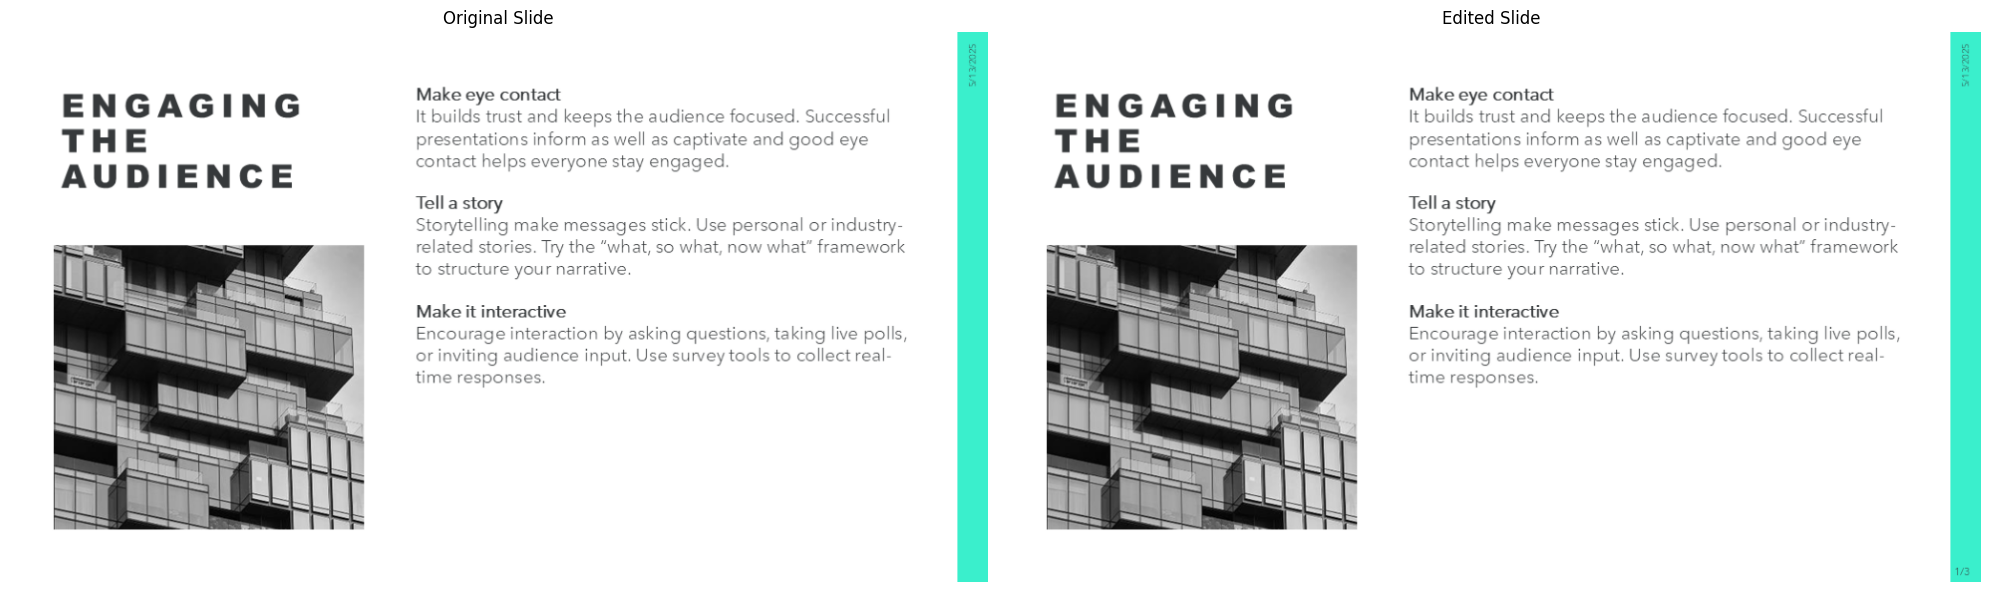


--- Original Slide Notes ---
1


--- Edited Slide Notes ---
1



In [33]:
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

# Configure paths
ROOT = Path(".")
ORIG_IMG_DIR = ROOT / "evaluation/benchmark_ppts/images"
ORIG_NOTE_DIR = ROOT / "evaluation/benchmark_ppts/notes"
EDIT_IMG_DIR = ROOT / "result/images" 
EDIT_NOTE_DIR = ROOT / "result/notes"
LOG_PATH = ROOT / "result/experiment_log.jsonl"

def load_first(path_glob: Path, exts=("*.png", "*.jpg", "*.jpeg")) -> Path:
    """Return first file path matched inside a directory."""
    for ext in exts:
        files = sorted(path_glob.glob(ext))
        if files:
            return files[0]
    raise FileNotFoundError(f"No image found in {path_glob}. Make sure the directory exists and contains image files.")

def display_before_after(input_str):
    """Display before and after images based on input string like '22-0'."""
    # Parse input string
    full_key = input_str  # 전체 키 (예: "22-0")
    
    # 하이픈 기준으로 분리
    parts = full_key.split('-')
    slide = int(parts[0])  # 슬라이드 번호 (예: 22)
    
    # Try to load instruction from log file
    instruction = "Unknown instruction"
    try:
        with open(LOG_PATH, "r", encoding="utf-8") as f:
            for line in f:
                log = json.loads(line)
                if str(log.get("slide_num")) == str(slide):
                    instruction = log.get("instruction", "Unknown instruction")
                    break
    except Exception as e:
        print(f"Warning: Could not load instruction from log file: {e}")
    
    # File paths
    orig_img_dir = ORIG_IMG_DIR / f"slide_{slide}"
    orig_note_dir = ORIG_NOTE_DIR / f"slide_{slide}"
    edit_img_dir = EDIT_IMG_DIR / f"result_slide_{slide}_instruction_{full_key}"
    edit_note_dir = EDIT_NOTE_DIR / f"result_slide_{slide}_instruction_{full_key}"
    
    # Load images and notes
    orig_img_path = load_first(orig_img_dir)
    edit_img_path = load_first(edit_img_dir)
    orig_note_file = next(iter(orig_note_dir.glob("*.txt")), None)
    edit_note_file = next(iter(edit_note_dir.glob("*.txt")), None)
    
    # Load notes content
    orig_note_content = orig_note_file.read_text(encoding="utf-8") if orig_note_file and orig_note_file.exists() else "No notes available"
    edit_note_content = edit_note_file.read_text(encoding="utf-8") if edit_note_file and edit_note_file.exists() else "No notes available"
    
    # Display the information
    print(f"Displaying Slide {slide} with Input Key {full_key}")
    print(f"\nInstruction: {instruction}")
    
    # Check if directories exist
    if not orig_img_dir.exists():
        print(f"Warning: Original image directory not found: {orig_img_dir}")
    if not edit_img_dir.exists():
        print(f"Warning: Edited image directory not found: {edit_img_dir}")
        
    # Load images - with error handling
    try:
        orig_img_path = load_first(orig_img_dir)
        print(f"Found original image: {orig_img_path}")
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return
        
    try:
        edit_img_path = load_first(edit_img_dir)
        print(f"Found edited image: {edit_img_path}")
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return
    
    # Display the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(Image.open(orig_img_path))
    axes[0].set_title("Original Slide")
    axes[0].axis('off')
    
    axes[1].imshow(Image.open(edit_img_path))
    axes[1].set_title("Edited Slide")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Display notes
    print("\n--- Original Slide Notes ---")
    print(orig_note_content)
    print("\n--- Edited Slide Notes ---")
    print(edit_note_content)

# Example usage
if __name__ == "__main__":
    # 방법 1: 직접 문자열로 입력 (예: "21-0")
    input_str = "51-6"  # 따옴표로 감싸서 문자열로 만듭니다
    display_before_after(input_str)
    
    # 방법 2: 사용자 입력 받기
    # input_str = input("Enter slide-instruction index (e.g., '21-0'): ")
    # display_before_after(input_str)

In [38]:
import json
import statistics
from collections import defaultdict
CATEGORY_MAP = {
  "0": "TextEditing",  "1": "TextEditing",   "2": "TextEditing",
  "3": "TextEditing",  "4": "TextEditing",   "5": "TextEditing",
  "6": "TextEditing",  "7": "TextEditing",   "8": "TextEditing",
  "9": "TextEditing", "10": "TextEditing",  "11": "VisualFormatting",
  "12": "VisualFormatting", "13": "TextEditing",  "14": "VisualFormatting",
  "15": "TextEditing", "16": "VisualFormatting",  "17": "LayoutAndImageAdjustment",
  "18": "VisualFormatting", "19": "TextEditing",  "20": "VisualFormatting",
  "21": "VisualFormatting", "22": "VisualFormatting", "23": "VisualFormatting",
  "24": "VisualFormatting", "25": "VisualFormatting", "26": "VisualFormatting",
  "27": "VisualFormatting", "28": "VisualFormatting", "29": "LayoutAndImageAdjustment",
  "30": "LayoutAndImageAdjustment", "31": "LayoutAndImageAdjustment",
  "32": "LayoutAndImageAdjustment", "33": "LayoutAndImageAdjustment",
  "34": "LayoutAndImageAdjustment", "35": "LayoutAndImageAdjustment",
  "36": "LayoutAndImageAdjustment", "37": "LayoutAndImageAdjustment",
  "38": "LayoutAndImageAdjustment", "39": "LayoutAndImageAdjustment",
  "40": "VisualFormatting", "41": "VisualFormatting", "42": "VisualFormatting",
  "43": "LayoutAndImageAdjustment", "44": "LayoutAndImageAdjustment",
  "45": "VisualFormatting", "46": "SlideStructure", "47": "SlideStructure",
  "48": "SlideStructure", "49": "LayoutAndImageAdjustment",
  "50": "SlideStructure", "51": "SlideStructure", "52": "SlideStructure",
  "53": "VisualFormatting", "54": "TextEditing", "55": "TextEditing"
}
def process_input_file(input_file_path):
    """Process JSON data from input file."""
    try:
        with open(input_file_path, 'r', encoding='utf-8') as f:
            data_string = f.read()
        
        # Parse the JSON data
        data = []
        for line in data_string.strip().split('\n'):
            if line.strip():
                try:
                    data.append(json.loads(line))
                except json.JSONDecodeError:
                    print(f"Error parsing JSON: {line}")
                    continue
        
        # Update categories and save the result
        update_categories_and_save(data)
        
    except Exception as e:
        print(f"Error processing input file: {str(e)}")

def update_categories_and_save(data):
    """Update categories based on instruction_key and save to output file."""
    
    # Update categories
    for entry in data:
        instruction_key = entry["instruction_key"]
        
        # Handle keys with a dash (like "6-2")
        if "-" in instruction_key:
            base_key = instruction_key.split("-")[0]
            if base_key in CATEGORY_MAP:
                entry["category"] = CATEGORY_MAP[base_key]
        else:
            if instruction_key in CATEGORY_MAP:
                entry["category"] = CATEGORY_MAP[instruction_key]
    
    # Save to output file
    output_file_path = "judge_results_ours.jsonl"
    with open(output_file_path, "w", encoding='utf-8') as f:
        for entry in data:
            f.write(json.dumps(entry) + "\n")
    
    print(f"Updated data saved to {output_file_path}")
    
    # Calculate and print category averages
    calculate_category_averages(data)

def calculate_category_averages(data):
    """Calculate and print average scores by category."""
    
    # Initialize data structures to collect scores by category
    instruction_scores = defaultdict(list)
    visual_scores = defaultdict(list)
    category_counts = defaultdict(int)
    
    # Collect scores by category
    for entry in data:
        category = entry.get("category", "Unknown")
        category_counts[category] += 1
        
        # 모든 점수를 추가 (0점 포함)
        instruction_scores[category].append(entry["instruction_adherence"])
        visual_scores[category].append(entry["visual_quality"])
    
    # Print the category averages
    print("\nCategory Averages:")
    for category in sorted(category_counts.keys()):
        ia_scores = instruction_scores[category]
        vq_scores = visual_scores[category]
        
        ia_avg = statistics.mean(ia_scores) if ia_scores else 0
        vq_avg = statistics.mean(vq_scores) if vq_scores else 0
        
        print(f"{category}:")
        print(f"  Total entries: {category_counts[category]}")
        print(f"  Instruction Adherence: {ia_avg:.2f} (Count: {len(ia_scores)})")
        print(f"  Visual Quality: {vq_avg:.2f} (Count: {len(vq_scores)})")

In [40]:
input_file = "judge_results_ours.jsonl"
    
process_input_file(input_file)

Updated data saved to judge_results_ours.jsonl

Category Averages:
LayoutAndImageAdjustment:
  Total entries: 95
  Instruction Adherence: 1.80 (Count: 95)
  Visual Quality: 4.02 (Count: 95)
SlideStructure:
  Total entries: 41
  Instruction Adherence: 1.71 (Count: 41)
  Visual Quality: 4.02 (Count: 41)
TextEditing:
  Total entries: 115
  Instruction Adherence: 2.95 (Count: 115)
  Visual Quality: 4.84 (Count: 115)
VisualFormatting:
  Total entries: 116
  Instruction Adherence: 1.98 (Count: 116)
  Visual Quality: 4.29 (Count: 116)
